In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Implementation of Vanilla GANs model
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [ ]:
# Run the comment below only when using Google Colab
!pip install torch torchvision

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
import numpy as np
import datetime
import os, sys

In [ ]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [ ]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [ ]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [ ]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [ ]:
n_noise = 100

In [ ]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [ ]:
from PIL import Image
import os

# Define a custom dataset class
class CustomDataset():
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Check if directory exists before listing files
        if not os.path.exists(root_dir):
            raise FileNotFoundError(f"Directory not found: {root_dir}")
        self.images = os.listdir(root_dir)  # Assuming all files in root_dir are images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        # Assume labels are derived from directory structure or filename
        label = 0  # Dummy label for illustration purposes

        return image, label

# Example usage - Make sure to provide a valid path here
# You can use an absolute path or a relative path from your current working directory
custom_dataset = CustomDataset(root_dir='/content/drive/MyDrive/Gen_DL Project @Sushant/inc_frames_gray', transform=transform)

In [ ]:
custom_dataset[0]

(tensor([[[-1.0000, -1.0000, -1.0000, -0.4431,  0.1216,  0.1137,  0.0902,
            0.0902,  0.0980,  0.1137,  0.1216,  0.1216,  0.1216,  0.1137,
            0.1059,  0.1059,  0.1059,  0.1451,  0.2941,  0.4510,  0.2392,
            0.1608,  0.1765,  0.2941, -0.2941, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -0.4196,  0.1451,  0.1216,  0.1059,
            0.1137,  0.1216,  0.1294,  0.1294,  0.1294,  0.1294,  0.1294,
            0.1216,  0.1216,  0.1216,  0.1294,  0.1529,  0.1686,  0.1686,
            0.1686,  0.2471,  0.4588, -0.2235, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -0.4118,  0.1451,  0.1216,  0.1137,
            0.1216,  0.1294,  0.1373,  0.1137,  0.1294,  0.1294,  0.1294,
            0.1294,  0.1294,  0.1294,  0.1294,  0.1451,  0.1529,  0.1451,
            0.1765,  0.3961,  0.5765, -0.2627, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -0.4118,  0.1373,  0.1216,  0.1137,
            0.1216,  0.1373,  0.160

In [ ]:
batch_size = 32

In [ ]:
data_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [ ]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [ ]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [ ]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 200 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 500 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/50, Step: 0, D Loss: 1.3927278518676758, G Loss: 0.712016761302948
Epoch: 3/50, Step: 200, D Loss: 1.1608738899230957, G Loss: 1.5141208171844482
Epoch: 7/50, Step: 400, D Loss: 1.349265694618225, G Loss: 0.7695333361625671
Epoch: 11/50, Step: 600, D Loss: 1.0990221500396729, G Loss: 1.8250758647918701
Epoch: 15/50, Step: 800, D Loss: 1.0960712432861328, G Loss: 1.4642078876495361
Epoch: 19/50, Step: 1000, D Loss: 1.26300048828125, G Loss: 1.4124540090560913
Epoch: 23/50, Step: 1200, D Loss: 1.0235204696655273, G Loss: 0.763276219367981
Epoch: 26/50, Step: 1400, D Loss: 1.1108427047729492, G Loss: 0.9632028937339783
Epoch: 30/50, Step: 1600, D Loss: 1.2341485023498535, G Loss: 1.1707005500793457
Epoch: 34/50, Step: 1800, D Loss: 1.0759432315826416, G Loss: 2.3304572105407715
Epoch: 38/50, Step: 2000, D Loss: 1.5424710512161255, G Loss: 0.9571279287338257
Epoch: 42/50, Step: 2200, D Loss: 1.164626955986023, G Loss: 1.7878004312515259
Epoch: 46/50, Step: 2400, D Loss: 1.08491897

## Visualize Sample

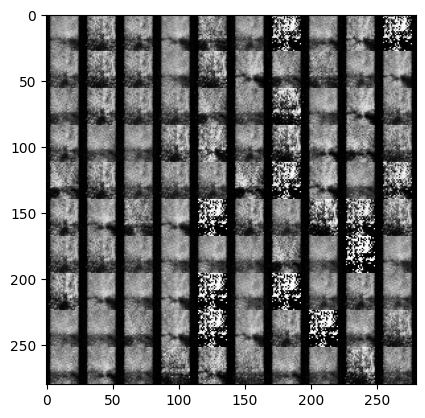

In [ ]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [ ]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')